# **Importing all the necessary libraries**

In [59]:
import os
import torch
import numpy
import math
import pandas
import random
from torch import nn
import torchvision
from torchvision import transforms
import sklearn.metrics
import matplotlib.pyplot as plt
from d2l import torch as d2l

# **Creating instances for the two datasets**

In [60]:
class FashionMNIST (d2l.DataModule):
  def __init__(self, batch_size=64, resize=(28,28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
    self.train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
    self.val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=trans, download=True)

In [61]:
class MNIST (d2l.DataModule):
  def __init__(self, batch_size=64, resize=(28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
    self.train = torchvision.datasets.MNIST(root=self.root, train=True, transform=trans, download=True)
    self.val = torchvision.datasets.MNIST(root=self.root, train=False, transform=trans, download=True)

# **Miscellaneous functions**

In [62]:
def sigmoid(z) :
  return 1 / (1 + torch.exp(-z) )

def categorizeData (source, target):
  n = min(len(source.train), len(target.val))
  main = list()
  for i in range(n) :
    s = source.train[i][0].reshape(28, 28)
    t = target.val[i][0].reshape(28, 28)
    main.append((s, 1))
    main.append((t, 0))
  return main

def getData (data) :
  features, labels = list(), list()
  for i in torch.randint(0, 20000, (100,)).tolist():
    features.append(data.train[i][0])
    labels.append(data.train[i][1])
  return [features, labels]

# **Creating a mixed dataset for the classifier**

In [63]:
class mixedData (d2l.DataModule):

  def __init__(self, source, target, batch_size=100):
    super().__init__()
    self.save_hyperparameters()
    self.train = categorizeData(source, target)
    self.batch_size = batch_size

  def get_dataloader(self, train):
    data = self.train
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)

# **The classifier for detecting and *correcting* the shift**

In [64]:
class LogisticRegression (d2l.Classifier):

  def __init__(self, lr=0.01, covariateShift=False, classifier=None):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(1), nn.Dropout(0.2), nn.Sigmoid())
    self.covariateShift = covariateShift
    self.classifier = classifier
    self.h = 1

  def forward (self, X):
    if self.covariateShift:
      self.h = torch.exp(torch.mean(self.classifier.predict(X, batch_size=100)))
    return self.net(X)

  def loss (self, y_hat, y, averaged=True):
    loss = nn.BCELoss()
    y = y.reshape(y_hat.shape).float()
    y_hat = y_hat.float()
    return self.h * loss(y_hat, y)

  def predict (self, feature, batch_size=1) :
    W = list()
    for weights in self.parameters():
      W.append(weights)
    if batch_size != 1 :
      Y = feature.reshape(batch_size, 28*28)
      return torch.matmul(Y, W[0].T.expand(28*28,batch_size)) + W[1].expand(1,batch_size)
    else :
      Y = feature.reshape(1, 28*28)
      return torch.matmul(Y, W[0].T) + W[1]

# **Training the classifier**

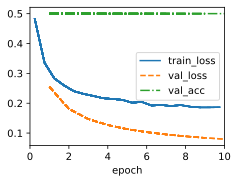

In [65]:
data = mixedData(FashionMNIST(resize=(28,28)), MNIST(resize=(28,28)))
classifier = LogisticRegression()
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(classifier, data)

In [66]:
f1, l1 = getData(data)

auc = sklearn.metrics.roc_auc_score
print("The AUC score before correction: ",auc(l1, [classifier.predict(i).tolist()[0] for i in f1]))

The AUC score before correction:  1.0


# **Using the classifier to correct the shift**

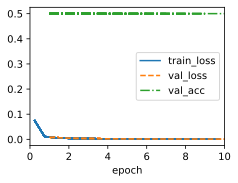

In [67]:
corrector = LogisticRegression (covariateShift=True, classifier=classifier)
trainer.fit(corrector, data)

In [70]:
f2, l2 = getData(data)
print("The AUC score after correction: ",auc(l2, [corrector.predict(i).tolist()[0] for i in f2]))

The AUC score after correction:  0.7771806531624638
